# Walidacja i Raport - ocena pracy innej grupy

In [1]:
import numpy as np
import pandas as pd
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

In [2]:
df_train_val_q = pd.read_csv("df_train_val_q.csv")
Xq_train = df_train_val_q.drop("label", axis=1)
yq_train = df_train_val_q['label']

df_valid_val_q = pd.read_csv("df_valid_val_q.csv")
Xq_valid = df_valid_val_q.drop("label", axis=1)
yq_val = df_valid_val_q['label']

df_train_val_c = pd.read_csv("df_train_val_c.csv")
Xc_train = df_train_val_c.drop("label", axis=1)
yc_train = df_train_val_c['label']

df_valid_val_c = pd.read_csv("df_valid_val_c.csv")
Xc_valid = df_valid_val_c.drop("label", axis=1)
yc_val = df_valid_val_c['label']

df_train_val_c_smote = pd.read_csv("df_train_val_c_smote.csv")
Xc_train_sm = df_train_val_c_smote.drop("label", axis=1)
yc_train_sm = df_train_val_c_smote['label']

In [4]:
X_test = pd.read_csv("df_test.csv")

In [5]:
X_test.head()

,Danceability,Loudness,Speechiness,Acousticness,Liveness,Valence,Tempo,Licensed,Artist_Length,Album_Length,Title_Length,Description_Length,AT_album,AT_compilation,Key_Low,new_Duration_ms,new_Instrumentalness,Views,Stream
0,-2.243792,-3.309550,0.379701,-0.075152,1.140665,-2.154630,-2.213898,1,1.561085,0.378528,1.759977,0.656371,1,0,0,-2.962047,1,433396.0,16377049.0
1,1.351918,-0.100423,0.460702,-0.008323,-1.461072,0.567990,-0.565188,1,-1.040394,1.004558,2.313515,0.183015,0,1,0,3.225096,0,1001264.0,874816.0
2,1.333635,0.995461,0.646943,-0.719894,-0.589226,0.572060,1.004013,1,0.043555,0.512872,0.099362,0.829993,1,0,1,-1.203751,0,1093996.0,10462306.0
3,0.169600,0.712567,-0.906741,-1.399299,0.416001,-0.669213,-1.332812,0,0.260345,0.636456,-0.403855,-1.253356,1,0,1,0.364682,0,1257912.0,9485200.0
4,-0.726281,-0.524499,-1.019746,0.202786,-0.098849,-1.271536,-1.026172,1,0.910715,-1.183361,-0.252890,0.547101,1,0,0,0.674636,0,45438287.0,105038362.0


### W df_test.csv i df_valid.csv nie ma tabeli label, która jest tutaj targetem. W takiej sytuacji ocenię modele.

Model przewidzuje to jak popularna jest piosenka na youtube. Przedziały popularności uzyskaliśmy za pomocą kasteryzacji "Views"(wyświetleń na youtube) i "Stream"(odsłuchań na spotify) przy pomocy KMenas i późniejszych przekształceń na uzyskanych klastrach. Z powodu dużej rozbieżności w liczności przedziałów zdecydowaliśmy się użyć oversamplingu przy pomocy smote.
Przedziały obejmują wartości o:<br>
|poziom popularności| mean(Views)  |   mean(Streams)| std(Views) | std(Streams)|
| ------------------| ------------ | -------------- | ---------- | ----------- |
|Low-popularity     |       ~2.7e7   |       ~5e7     |     ~4.8e7 |      ~4.7e7 |
|Medium-popularity   |       ~2e8     |       ~4e8     |     ~1.8e8 |      ~2.6e8 |
|High-popularity     |       ~1.3e9   |       ~8.8e8   |     ~8.7e8 |      ~6.4e8 |

## Walidacja modelu 1

Random Forest with smote
                   precision    recall  f1-score   support

  High-popularity       0.27      0.31      0.29       117
   Low-Popularity       0.84      0.88      0.86      3085
Medium-popularity       0.40      0.31      0.35       740

         accuracy                           0.75      3942
        macro avg       0.50      0.50      0.50      3942
     weighted avg       0.74      0.75      0.75      3942



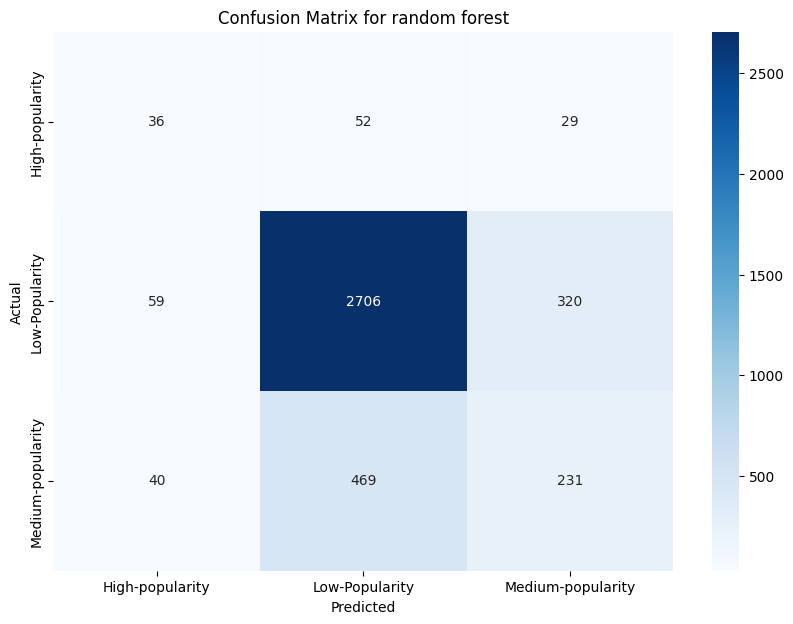

In [4]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, max_depth=None, max_features="log2",random_state=42)

rf.fit(Xc_train_sm, yc_train_sm)

rf_preds = rf.predict(Xc_valid)

print("Random Forest with smote")
print(classification_report(yc_val, rf_preds,target_names = ["High-popularity","Low-Popularity","Medium-popularity"]))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yc_val, rf_preds)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=["High-popularity","Low-Popularity","Medium-popularity"], yticklabels=["High-popularity","Low-Popularity","Medium-popularity"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for random forest')
plt.show()

### Ocena Modelu 1
Sukces nie powala, 75% skuteczności można poprawić - widzimy ponadto na czym się skupić - często mylone jest Low-Popularity z Medium-Popularity
## Walidacja modelu 2

Ten model został stworzony na tej samej zasadzie co poprzedni, ale nie użyliśmy oversamplingu.

XGBoost with tuned hyperparemeters
                   precision    recall  f1-score   support

  High-popularity       0.86      0.16      0.27       117
   Low-Popularity       0.81      0.99      0.89      3085
Medium-popularity       0.75      0.15      0.25       740

         accuracy                           0.81      3942
        macro avg       0.81      0.43      0.47      3942
     weighted avg       0.80      0.81      0.75      3942



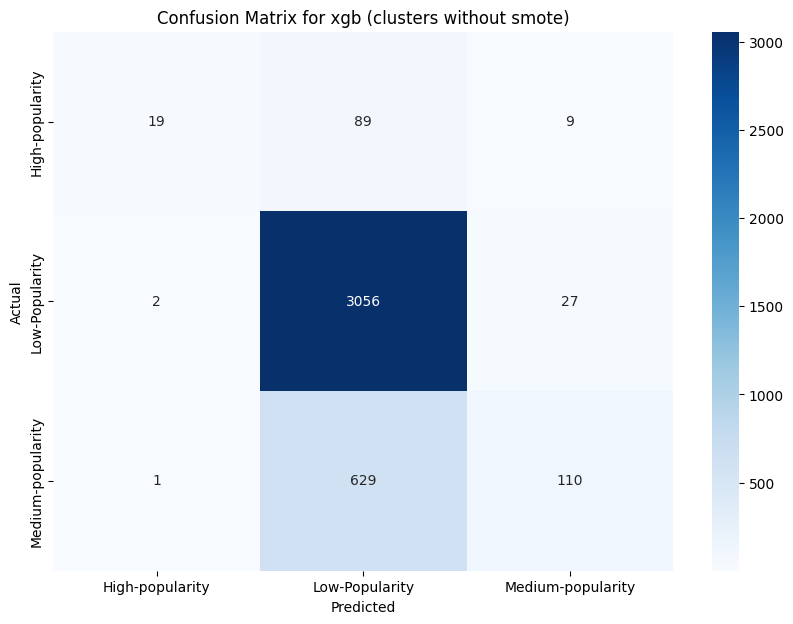

In [6]:
#CLUSTER without SMOTE
#XGBoost model with RandomizedSearchCV
from xgboost import XGBClassifier
xgb = XGBClassifier(objective='multi:softmax', subsample= 1.0, n_estimators= 200, max_depth= 10, learning_rate=0.1, colsample_bytree= 0.5)
xgb.fit(Xc_train, yc_train)

xgb_preds = xgb.predict(Xc_valid)

print("XGBoost with tuned hyperparemeters")
print(classification_report(yc_val, xgb_preds,target_names = ["High-popularity","Low-Popularity","Medium-popularity"]))

from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(yc_val, xgb_preds) 
plt.figure(figsize=(10,7)) 
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=["High-popularity","Low-Popularity","Medium-popularity"], yticklabels=["High-popularity","Low-Popularity","Medium-popularity"]) 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.title('Confusion Matrix for xgb (clusters without smote)') 
plt.show()

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay

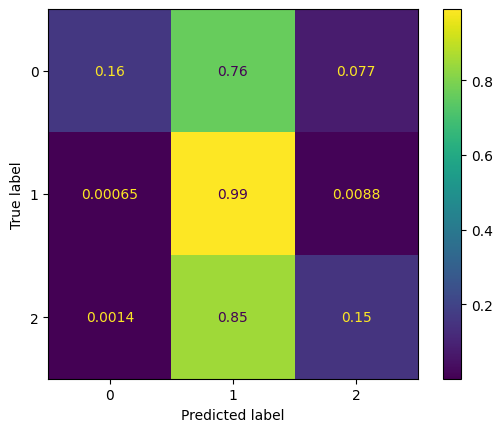

In [12]:
ConfusionMatrixDisplay.from_predictions(y_true=yc_val, y_pred=xgb_preds, normalize="true")

### Ocena modelu 2
Co możemy zauważyć po znormalizowaniu? Wszystkie piosenki są z grubsza przypisywane jako mało popularne.

Ten model przewiduje popularność piosenki na youtube w 3 przedziałach, ale tym razem granicami przedziałow są kwantyl 1/3(~4e6) i kwantyl 2/3(~41e6) kolumny "Views" dla training seta.<br>
przedziały obejmują wartości:<br>
High - (~41e6,+inf)<br>
Medium - (~4e6, ~41e6)<br>
Low - (0,~4e6)


## Walidacja modelu 3

XGBoost - Classification Report
              precision    recall  f1-score   support

        High       0.59      0.66      0.62      1403
         Low       0.61      0.64      0.62      1331
      Medium       0.48      0.39      0.43      1316

    accuracy                           0.57      4050
   macro avg       0.56      0.56      0.56      4050
weighted avg       0.56      0.57      0.56      4050



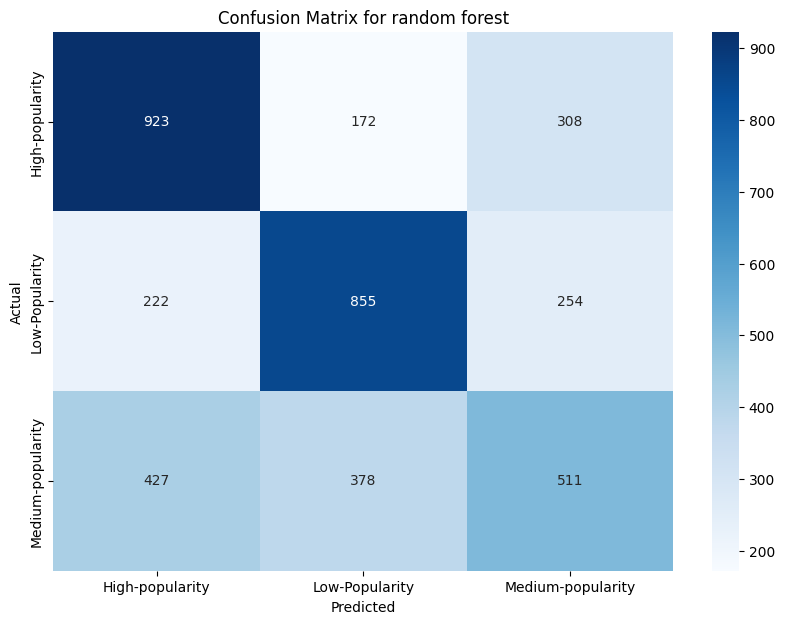

In [13]:
#XGB
from xgboost import XGBClassifier
xgb_q = XGBClassifier(objective='multi:softmax',subsample=1.0, n_estimators=200, max_depth=7, learning_rate=0.1, colsample_bytree=0.5)

xgb_q.fit(Xq_train,yq_train)

xgb_q_preds = xgb_q.predict(Xq_valid)

print("XGBoost - Classification Report")
print(classification_report(yq_val, xgb_q_preds,target_names=["High","Low","Medium"]))

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(yq_val, xgb_q_preds)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=["High-popularity","Low-Popularity","Medium-popularity"], yticklabels=["High-popularity","Low-Popularity","Medium-popularity"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for random forest')
plt.show()

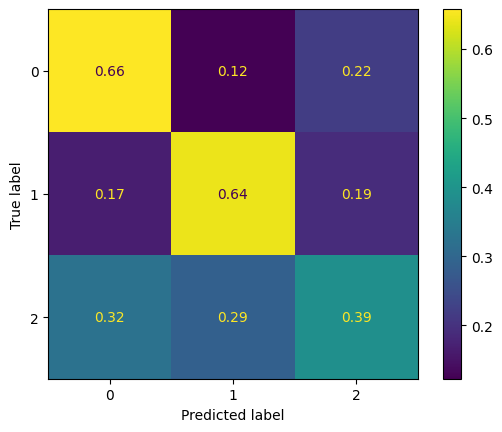

In [14]:
ConfusionMatrixDisplay.from_predictions(y_true=yq_val, y_pred=xgb_q_preds, normalize="true")

### Ocena
Ponownie widzimy model, który niestety nie jest zbyt skuteczny.

# Ocena projektu
## Uzycie klasteryzacji
1. Został wybrany zły punkt przegięcia w 'Elbow Method' - wg. mnie lepszy byłby 4 lub 3.
2. Same klastry niewiele 
## Szukanie hiperparametrów
1. Zostało użytych mało modeli
2. Mimo, że SVC osiągnęło najlepsze wyniki, nie zostało uwzględnione w modelach do sprawdzenia.
3. Głębokości drzew w RandomForest i XGBoost nie przekraszają 10 - skąd wiemy, że dalej nie ma optymalnych?
4. Przez cały proces szukania nie została zwrócona uwaga na to, że wszystkie klasy oprócz 'low-popularity' są tragicznie przewidywane - używano niezmormalizowanych macierzy pomyłek, które na pierwszy rzut oka wyglądają w porządku, ale jak się je znormalizuje wg. prawdziwej etykietki to przestają dobrze wyglądać.
## Ogólne wnioski:
1. Etykietki, które zostały utworzone nie są do końca najlepsze - możnaby popróbować z innymi, np.dać ich więcej lub przynajmniej zmniejszych przedziały tak, żeby było mniej tych z minimalną popularnością.
2. Rzadka siatka podczas GridSearch - nie wiemy, czy istnieje lepsze rozwiązania.
3. Brak innych estymatorów, np. KNN czy drzew decyzyjnych.

## Podsumowanie
Włożone zostało sporo pracy, która przyniosła efeky, które niestety nie są powalające. Stuteczność jest na dość niskim poziomie, a żadne idee poprawy poprzez zbalansowanie etykietek nie zostały wprowadzone. Ponadto ramki danych, które miały służyć do walidacji nie są odpowiednio przygotowane - nie ma w nich kolumny 'label' oraz nie są przeskalowane.
